# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MCHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using PyPlot

using Revise
using MCHMC

[ Info: Precompiling MCHMC [92da4d09-9da0-4f8a-8b31-da41ef0ab6ee]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
mchmc = Sampler(0.0, sqrt(target.d)*0.01, varE_wanted=2.0)

Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.014142135623730952, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [9]:
samples_mchmc = Sample(mchmc, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 34.83562307649745
eps: 0.125 --> VarE: 42.51340333088257
eps: 0.0625 --> VarE: 10.611844953344532
eps: 0.03125 --> VarE: 3.5875473832850746
eps: 0.015625 --> VarE: 1.542419024646851


[ Info: Found eps ✅


Row,Ω,stats
,Any,Any
1,"[0.216364, 0.425911]","[0.0, -50.433]"
2,"[0.216364, 0.425911]","[5.14237, -45.2523]"
3,"[0.222778, 0.440159]","[12.5688, -40.458]"
4,"[0.224469, 0.455692]","[9.88917, -35.772]"
5,"[0.23376, 0.468255]","[7.70979, -32.3097]"
6,"[0.247709, 0.475295]","[7.52658, -27.8689]"
7,"[0.254914, 0.48916]","[12.5671, -23.5906]"
8,"[0.260743, 0.503657]","[8.44804, -22.3984]"
9,"[0.248317, 0.513129]","[2.17077, -18.9701]"


In [10]:
plt.plot(samples_mchmc.E[8000:end])

LoadError: ArgumentError: column name "E" not found in the data frame; existing most similar names are: "Ω"

In [11]:
mean(samples_mchmc.E[8000:end])

LoadError: ArgumentError: column name "E" not found in the data frame; existing most similar names are: "Ω"

In [12]:
std(samples_mchmc.E[8000:end])^2/target.d

LoadError: ArgumentError: column name "E" not found in the data frame; existing most similar names are: "Ω"

In [13]:
Wms_mchmc = [sample[1] for sample in samples_mchmc.Ω]
s8s_mchmc = [sample[2] for sample in samples_mchmc.Ω];

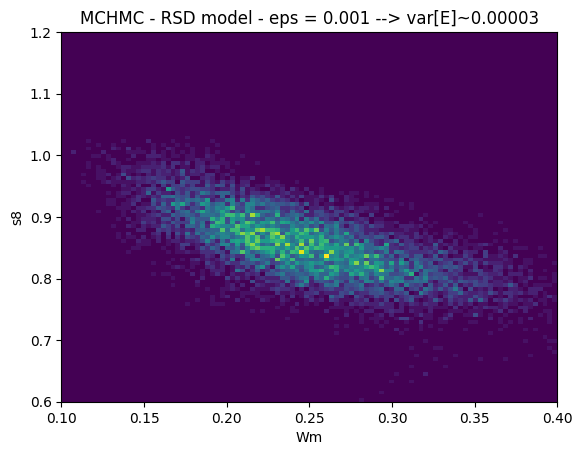

In [14]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [15]:
mchmc = Sampler(0.0, sqrt(target.d)*0.01, varE_wanted=2.0)

Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.014142135623730952, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [20]:
samples = sample(stat_model, mchmc, 10000;
                 monitor_energy=true, 
                 dialog=true)

Using given hyperparameters


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


10000-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.13754466541487348, 0.7963465741380666], [0.0, 8.831153012414545])
 ([0.13754466541487348, 0.7963465741380666], [1.9634465283271467, 13.93250893740241])
 ([0.16232041057623137, 0.8153919135075672], [9.786332715104866, 17.011538628971675])
 ([0.1909990622659477, 0.8278055123918526], [7.32573075995742, 18.568925116602635])
 ([0.218828427222422, 0.8420213115645816], [1.7449234772654414, 17.080936386468185])
 ([0.1893592686582426, 0.8316226965837655], [-2.7891256775086894, 17.6460280759011])
 ([0.18047189455590795, 0.8615822873948089], [0.5238668337430887, 18.03616297282658])
 ([0.17553017977262064, 0.8924390849441438], [0.5873286458243605, 18.51993547232737])
 ([0.19825620428726845, 0.8709893691008133], [1.01903760397661, 18.86908597265919])
 ([0.22628056682177966, 0.857161946906699], [-0.06526624972726935, 18.106103110393857])
 ([0.19525136479272392, 0.8534536964512895], [-1.3152472660301768, 18.586885725860146])
 ([0.196

In [17]:
params = []
internals = []
for sample in samples
    param, internal = sample
    push!(params, param)
    push!(internals, internal)
end

In [18]:
internals

10000-element Vector{Any}:
 [0.0, 17.407881123062033]
 [-0.024783437653617568, 17.2223761407182]
 [-0.5267654001366573, 15.870830359978166]
 [-0.7797609523330618, 17.581524861301986]
 [2.614957994163257, 18.037742726428274]
 [0.8962904882106422, 18.37015187436895]
 [1.1256936428571471, 18.755210366124818]
 [0.4126256851368595, 18.38090285436362]
 [-0.37149557247564857, 18.746431085328737]
 [0.3874697277182477, 18.414746406154368]
 [-0.779796059632325, 18.127299973417355]
 [-0.6606251236797753, 17.54328563895838]
 [-0.549944418757832, 16.463464904288333]
 ⋮
 [-2.020149730642114, 18.211229145282893]
 [1.3909274392353979, 18.88818699098282]
 [1.361692303101922, 18.90677161160427]
 [-0.11921642982049008, 18.75256059745194]
 [-0.676807017188171, 18.34823819428463]
 [-0.734356693108623, 18.38493182650424]
 [0.22579343281255504, 18.460412359699205]
 [0.23770182992485545, 18.570358245668817]
 [-0.1922609027240263, 18.173286646246343]
 [-0.34002473129912403, 18.680512522550078]
 [0.730135771470

In [19]:
smps = MCMCChains.concretize(vals)

LoadError: UndefVarError: `vals` not defined

## NUTS

In [19]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 7.96 seconds
Compute duration  = 7.96 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2546    0.0579     0.0006    0.0011   2906.8709    0.9999    ⋯
          σ8    0.8501    0.0534     0.0005    0.0010   2935.7125    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [90]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.226487  0.986209  13.5908  3.0  1.0  …  2.0  0.0  0.672144  0.672144
 0.20474   0.758337  13.5104  7.0  1.0     2.0  0.0  0.672144  0.672144
 0.461568  0.83525   11.5659  7.0  1.0     2.0  0.0  0.672144  0.672144
 0.232626  0.797017  17.5158  7.0  1.0     3.0  0.0  0.672144  0.672144
 0.230155  0.897164  18.4408  7.0  1.0     2.0  0.0  0.672144  0.672144
 0.182186  0.896348  18.2925  3.0  1.0  …  2.0  0.0  0.672144  0.672144
 0.260894  0.850705  18.8292  7.0  1.0     2.0  0.0  0.672144  0.672144
 0.271235  0.791219  18.1031  7.0  1.0     2.0  0.0  0.672144  0.672144
 0.24796   0.754759  15.6767  3.0  1.0     2.0  0.0  0.672144  

In [20]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

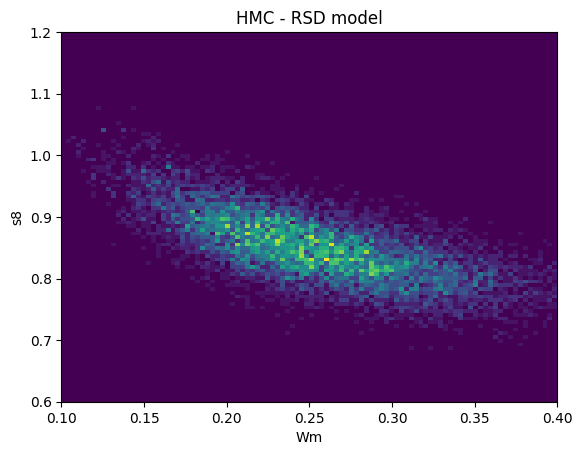

In [21]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");